In [1]:
%load_ext autoreload
%autoreload 2
import os
import sys
import time
import json
import glob
import torch
import math
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from IPython import display
from tqdm.notebook import tqdm

# Data structures and functions for rendering
from pytorch3d.structures import Volumes
from pytorch3d.transforms import so3_exp_map
from pytorch3d.renderer import (
    FoVPerspectiveCameras,
    NDCMultinomialRaysampler,
    MonteCarloRaysampler,
    EmissionAbsorptionRaymarcher,
    ImplicitRenderer,
    RayBundle,
    ray_bundle_to_ray_points,
)
import sys

sys.path.append('/home/azhuavlev/PycharmProjects/ml-neuman_mano/pytorch3d_nerf')
from mano_custom import mano_pytorch3d

device = torch.device("cuda:0")
import kaolin
import warping.kaolin_test as kaolin_test

kaolin_test.test_kaolin()
hand_model = mano_pytorch3d.create_mano_custom(return_right_hand=False)

checking kaolin...
check_sign tensor([[ True, False, False, False, False, False, False, False, False, False,
         False, False, False,  True, False, False, False,  True, False, False,
         False, False, False,  True, False,  True, False]], device='cuda:0')
point_to_mesh_distance tensor([[ 0.2500, 41.0000]], device='cuda:0') tensor([[0, 0]], device='cuda:0') tensor([[5, 5]], device='cuda:0', dtype=torch.int32)
Fix shapedirs bug of MANO


/scratch_net/manifoldnet/azhuavlev/conda_envs/neuman_kaolin_fairnr/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1670525539683/work/aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [2]:
import trimesh

faces_zero_pose = torch.from_numpy(hand_model.faces.astype(np.int32))[None, :, :]
verts_zero_pose = hand_model.get_flat_hand_vertices_pytorch3d('cpu')

mesh = trimesh.Trimesh(vertices=verts_zero_pose[0], faces=faces_zero_pose[0])
boundary_vertices = [92, 38, 122, 118, 117, 119, 120, 108, 79, 78, 121, 214, 215, 279, 239, 234][::-1]

centroid = mesh.vertices[boundary_vertices].mean(axis=0)
vertices_repaired = np.append(verts_zero_pose[0], centroid[None, :], axis=0)

new_faces = []
for i in range(len(boundary_vertices) - 1):
    next_i = i + 1 % len(boundary_vertices)
    new_faces.append([len(vertices_repaired) - 1, boundary_vertices[i], boundary_vertices[next_i]])
new_faces.append([len(vertices_repaired) - 1, boundary_vertices[len(boundary_vertices) - 1], boundary_vertices[0]])

faces_repaired = np.append(faces_zero_pose[0], new_faces, axis=0)

mesh_repaired_trimesh = trimesh.Trimesh(vertices=vertices_repaired, faces=faces_repaired)
print(mesh_repaired_trimesh.is_watertight)

True


In [3]:
import livehand.input_encoder as input_encoder

In [4]:
vt, ft, f = input_encoder.read_mano_uv_obj('/itet-stor/azhuavlev/net_scratch/Projects/Data/models/mano/uv_maps/MANO_UV_left.obj')
#vt: uv coordinates of the vertices of the MANO mesh                #(891, 2), range: [0, 1]
#ft: MANO mesh face indices for vt                                  #(1538, 3), range: [0, 890]
#f: MANO mesh face indices for the vertices of the MANO mesh        #(1538, 3), range: [0, 777]
mesh_faces = torch.tensor(f)                                    #NOTE: this is same as mano_layer[hand_type].faces
mesh_face_uv = torch.tensor(vt[ft], dtype=torch.float32)        #torch.Size([1538, 3, 2])   #Neural Actor encoder.py line 1244

In [12]:
import warping.get_vertex_uv as get_vertex_uv
uv_finder = get_vertex_uv.VertexUVFinder()
print('uv_finder.faces_uvs_index', uv_finder.faces_uvs_index, uv_finder.faces_uvs_index.shape)
print('mesh_face_uv', mesh_face_uv, mesh_face_uv.shape)

uv_finder.faces_uvs_index tensor([[[0.2531, 0.4262],
         [0.2569, 0.3909],
         [0.2802, 0.4381]],

        [[0.2802, 0.4381],
         [0.2569, 0.3909],
         [0.2835, 0.4006]],

        [[0.2721, 0.3198],
         [0.2499, 0.3230],
         [0.2764, 0.2818]],

        ...,

        [[0.2423, 0.3529],
         [0.2162, 0.3741],
         [0.2233, 0.3507]],

        [[0.2341, 0.3822],
         [0.2292, 0.4137],
         [0.2162, 0.3741]],

        [[0.2162, 0.3741],
         [0.2292, 0.4137],
         [0.2129, 0.4050]]]) torch.Size([1538, 3, 2])
mesh_face_uv tensor([[[0.2531, 0.5738],
         [0.2569, 0.6091],
         [0.2802, 0.5619]],

        [[0.2802, 0.5619],
         [0.2569, 0.6091],
         [0.2835, 0.5994]],

        [[0.2721, 0.6802],
         [0.2499, 0.6770],
         [0.2764, 0.7182]],

        ...,

        [[0.2423, 0.6471],
         [0.2162, 0.6259],
         [0.2233, 0.6493]],

        [[0.2341, 0.6178],
         [0.2292, 0.5863],
         [0.2162, 0.6259

(0.0, 1.0)

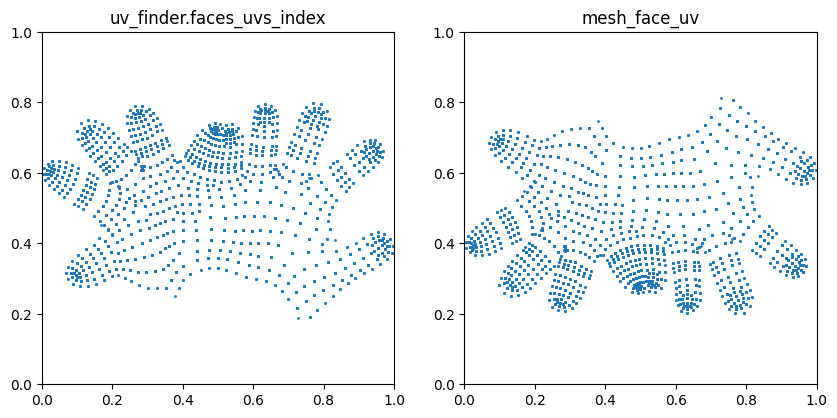

In [15]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(121)
ax.scatter(
    x=uv_finder.faces_uvs_index.reshape(-1, 2)[:, 0].cpu().numpy(),
    y=uv_finder.faces_uvs_index.reshape(-1, 2)[:, 1].cpu().numpy(),
    s=1)
ax.set_title('uv_finder.faces_uvs_index')

ax.set_aspect('equal', adjustable='box')
# set axes limits 0 to 1
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)

ax = fig.add_subplot(122)
ax.scatter(
    x=mesh_face_uv.reshape(-1, 2)[:, 0].cpu().numpy(),
    y=mesh_face_uv.reshape(-1, 2)[:, 1].cpu().numpy(),
    s=1)
ax.set_title('mesh_face_uv')

# set axes equal
ax.set_aspect('equal', adjustable='box')
# set axes limits 0 to 1
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)

In [10]:
points_to_query = torch.rand(1, 5000, 3) * 0.5 - 0.25

pts_uv, pts_d, intermediates = input_encoder.get_uvd(points_to_query, verts_zero_pose[0], faces_zero_pose[0], mesh_face_uv)
print(pts_uv)
print(pts_d)
print('intermediates', intermediates)

RuntimeError: No CPU implementation.

torch.Size([1, 1538, 3])